# Structuring Unstructered Data Using ChatGPT

In [23]:
import pandas as pd
import numpy as np
import openai
import matplotlib.pyplot as plt

In [2]:
job_descriptions = pd.read_csv('linkedin_data_scientist_job_descriptions.csv') 

Initial file contains 50 Remote Data Scientist job descriptions from LinkedIn.  
The fields include data that is structured within the job descriptions as well as the unstructured "Description" field that contains the text description of the job.

In [3]:
job_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   JobID           50 non-null     int64 
 1   Title           50 non-null     object
 2   Company         50 non-null     object
 3   Url             50 non-null     object
 4   Location        50 non-null     object
 5   Category        50 non-null     object
 6   SeniorityLevel  50 non-null     object
 7   EmploymentType  50 non-null     object
 8   JobFunction     50 non-null     object
 9   Industries      50 non-null     object
 10  PostedTime      50 non-null     object
 11  PostedDate      50 non-null     object
 12  NumApplicants   50 non-null     object
 13  Description     50 non-null     object
dtypes: int64(1), object(13)
memory usage: 5.6+ KB


In order to extract more structured data from the job description, the following code passes the "description" text field to ChatGPT along with specific instructions on what data to extract and how to format the results. 

There are three different sections, each focusing on extracting a different set of data: 
1. Required Job Experience
2. Salary
3. Technical Skills

## Process and Prompts

In order to access the Open AI API, first provide the api_key.

In [ ]:
openai.api_key = api_key_here

For each session/conversation with ChatGPT, there is a "System" and a "User" role. For each session a prompt is provided for both roles. Below is a description of each role according to ChatGPT.
  
System Role - Used to define the behavior, personality, or context of the assistant before the actual conversation starts. The purpose of the systems prompt is to set the initial instructions for the assistant and help steer the tone, expertise, boundaries or other aspects of how the assistant should respond. It is submitted once per conversions/session.  

User Role - Represents input from the end user. It is the prompt or question that the system is expected to respond to. The "user_prompt" in the code below is written to be submitted with each job description.

## Extracting Job Experience Requirement

This first request from ChatGPT is to classify job descriptions into one of five experience level buckets based on the number of years of professional experience listed in the job description.  
The requestd output is a single digit between 1-5 indicating the experience level based on the rubric provided in the prompt.

In [5]:
#Prompt for System Role
system_prompt_exp = """You are a recruiting assistant. Your task is to classify job descriptions into one of five experience level buckets based on the number of years of professional experience listed in the job description.

The experience level buckets are:

1. Entry Level (0-2 years)
2. Junior Level (2-5 years)
3. Mid Level (5-10 years)
4. Senior Level (10-15 years)
5. Executive Level (15+ years)

When given a job description, analyze the text to determine the total years of professional experience and classify the resume into the appropriate experience level bucket."""


In [6]:
#Prompt for User Role
user_prompt_exp = lambda jobdescrip: f"""I have a job description, and I need to identify the required experience level. Here are the experience level buckets:

1 = Entry Level (0-2 years)
2 = Junior Level (2-5 years)
3 = Mid Level (5-10 years)
4 = Senior Level (10-15 years)
5 = Executive Level (15+ years)

Please analyze the following job description text and identify the desired experience level. Ensure your response is a single digit between 1-5 indicating the experience level based on the above rubric.

### Job Description

{jobdescrip}

"""

Following code loops through each job description, prompts ChatGPT to extract the requested data and compiles the ChatGPT output.

In [7]:
exp_level_list = []

# Extract Experience Data for Each JD
for i in range(len(job_descriptions)):
    
    prompt = user_prompt_exp(job_descriptions['Description'][i])
    
    response = openai.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": system_prompt_exp},
        {"role": "user", "content": prompt}
      ],
      n=1,
      temperature = 0.1
    )
    
    exp_level_list.append(response.choices[0].message.content)

Compiled output from the job experience request is a list of numbers (output as strings) indicating the level of required experience within each job description

In [8]:
print(exp_level_list[:5])

['3', '3', '2', '3', '1']


Final step in the job experience request is to convert the compiled ChatGPT output to integers and then add it to the job_description dataframe

In [9]:
exp_level_arr = np.array(exp_level_list).astype(int)
job_descriptions['exp_level'] = exp_level_arr

## Extracting Salary

Similar to the job experience request, the salary request ask ChatGPT to classify each job description into salary buckets. In addition, the prompt requests that ChatGPT returns the salary range provided in the job description. There are specfic instructions on how to output the data so it can easily be parsed and added to the job description dataframe.   

In [10]:
#Prompt for System Role
system_prompt_salary = """You are a recruiting assistant. Your task is to classify job decriptions into one of five salary level buckets based on the salary range listed in the job description. 

Classify the salary based on the upper bound of salary range provided in the job description.

The experience level buckets are:

0. Salary Not Provided
1. < $100K
2. $101K-$150K
3. $151K-$175K
4. $176K-$200K
5. $201K-$250K
6. > $250K

When given a job description, analyze the text to determine the total years of professional experience and classify the resume into the appropriate experience level bucket."""

In [11]:
#Prompt for User Role
user_prompt_salary = lambda jobdescrip: f"""I have a job description, and I need to identify the salary level provided in the description. Here are the salary buckets:

0 = Salary Not Provided
1 = < $100K
2 = $101K-$150K
3 = $151K-$175K
4 = $176K-$200K
5 = $201K-$250K
6 = > $250K

Analyze the following job description text and identify the salary. 

Provide two outputs:
1. Provide the salary range given in the job description
2. Provide the single digit between 0-6 indicating the salary level based on the above rubric.

Format the outputs as follows: 

Salary Range ; 0-5

### Job Description

{jobdescrip}
"""

As with the job experience request, the following code loops through each job description, prompts ChatGPT to extract the requested data and compiles the ChatGPT output.

In [12]:
salary_level_list = []

# Extract Salary Data for Each JD
for i in range(len(job_descriptions)):
    
    prompt = user_prompt_salary(job_descriptions['Description'][i])
    
    response = openai.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": system_prompt_salary},
        {"role": "user", "content": prompt}
      ],
      n=1,
      temperature = 0.1
    )
    
    salary_level_list.append(response.choices[0].message.content)

Compiled ChatGPT output of the salary request is a list of strings. Each strings contains the salary range, a semicolon and then a number indicating the salary bucket for each job description.

In [13]:
print(salary_level_list)

['$170,000 - $720,000 ; 6', '$100,000 - $720,000 ; 6', '$160,000 to $180,000 ; 4', 'Salary Range ; 0', '$129,232 - $232,617 ; 5', 'Salary Range ; 0', '$150,000 - $750,000 ; 6', '$170,000 - $720,000 ; 6', '$145,000/year to $204,000/year ; 4', 'Salary Range: $62-$65/hour ; 1', 'Salary Range: $62.94-$67.96 per hour ; 1', 'Salary Range ; 0', '$101,382—$209,296 USD ; 4', 'Salary Range ; 0', 'Salary Range ; 0', 'Salary Not Provided ; 0', '$55k-$70k ; 1', '$150,000 - $750,000 ; 6', 'Salary Range ; 0', 'Salary Range ; 0', 'Salary Range: $59,902.68 – $110,630.79 ; 2', '$45-60/hr ; 1', 'Salary Range: Salary Not Provided ; 0', '$148,617 - $267,510 ; 6', '$45.05 - $50.05/hr ; 1', 'Salary Range ; 0', '$150,000 - $205,000 ; 4', '$194,000—$240,000 USD ; 5', '$81,600 - $110,400 ; 2', 'Salary Range ; 0', 'Salary Range: Salary Not Provided ; 0', 'Salary Range ; 0', 'Salary Range: $70,907 to $147,900/year ; 2', 'Salary Range: $180K - $240K ; 5', 'Salary Range ; 0', 'Salary Range ; 0', 'Salary Range: $93,

Final code in the salary request uses the comma to split the ChatGPT output into two seperate lists (salary and salary_bucket) and adds each array to the job_description dataframe.

In [ ]:
# Create Empty Lists
salary = []
salary_bucket = []

# Split each item in the list on the comma
for item in salary_level_list:
    parts = item.rsplit(';', 1)
    salary.append(parts[0].strip())
    salary_bucket.append(parts[1].strip())

# Add lists to the Job Description dataframe
job_descriptions['salary'] = salary
job_descriptions.loc[job_descriptions['salary'] == 'Salary Range', 'salary'] = 'No Salary Provided'
job_descriptions['salary_bucket'] = salary_bucket
job_descriptions['salary_bucket'] = job_descriptions['salary_bucket'].astype(int)

## Extracting Techinical Skills

In the final request, the prompt to ChatGPT provides a list of technical skills and requests an output indicating whether or not each technical skill is mentioned in the job description. 

In [15]:
#Prompt for System Role
system_prompt_skills = """You are a recruiting assistant. Your task is to identify the technical skills required within the job describtions.

You are to identify whether the following technical skills are present in the job description: 

SQL, R, Python, A/B Testing, ETL, Data Visualization, Machine Learning, AI, BigQuery, Snowflake """

In [16]:
#Prompt for User Role
prompt_template_skills = lambda jobdescrip: f"""I have a job description, and I need to identify the technical skills required within the job describtions.

Here are the technical skills of interest:

SQL, R, Python, A/B Testing, Data Modeling, Data Visualization, Machine Learning

Analyze the following job description text and determine whether the technical skills of interest are mentioned in the job description

For the output, list each technical skill of interest following by a ":" and then a "1" if the skill is mentioned in the job description or a "0" if the skill is not mentioned. 

Here is an example output. In this example, every technical skill of interest is present in the job description

SQL:1 , R:1, Python:1, A/B Testing:1, Data Modeling:1, Data Visualization:1, Machine Learning:1

### Job Description

{jobdescrip}

"""

In [18]:
skills_list = []

# extract YoE for each resume in df
for i in range(len(job_descriptions)):
    
    prompt = prompt_template_skills(job_descriptions['Description'][i])
    
    response = openai.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": system_prompt_skills},
        {"role": "user", "content": prompt}
      ],
      #max_tokens=1,
      n=1,
      temperature = 0.1
    )
    
    skills_list.append(response.choices[0].message.content)

Compiled ChatGPT output is a list of strings. Each strings contains the technical skill followed by a 0 or 1, indicating whether the skill was mentioned in the job description

In [19]:
print(skills_list[0:10])

['SQL:1, R:0, Python:1, A/B Testing:1, Data Modeling:0, Data Visualization:0, Machine Learning:0', 'SQL:0, R:0, Python:1, A/B Testing:1, Data Modeling:0, Data Visualization:0, Machine Learning:1', 'SQL:1, R:0, Python:0, A/B Testing:1, Data Modeling:0, Data Visualization:1, Machine Learning:0', 'SQL:0, R:0, Python:1, A/B Testing:0, Data Modeling:0, Data Visualization:0, Machine Learning:1', 'SQL:0, R:0, Python:1, A/B Testing:0, Data Modeling:0, Data Visualization:0, Machine Learning:1', 'SQL:0, R:1, Python:1, A/B Testing:0, Data Modeling:0, Data Visualization:0, Machine Learning:1', 'SQL:0, R:0, Python:1, A/B Testing:0, Data Modeling:0, Data Visualization:0, Machine Learning:1', 'SQL:1, R:1, Python:1, A/B Testing:0, Data Modeling:1, Data Visualization:0, Machine Learning:0', 'SQL:1, R:1, Python:1, A/B Testing:1, Data Modeling:0, Data Visualization:0, Machine Learning:1', 'SQL:0, R:0, Python:1, A/B Testing:0, Data Modeling:0, Data Visualization:0, Machine Learning:1']


Final step in the technical skills extraction is to convert the output to a dictionary and then into a dataframe. Within the dataframe each techinical skill is a column header and the rows are flags indicating whether the skill is present in the job description. The skills dataframe is then appended to the job description dataframe. 

In [20]:
# Split each entry into a dict
skills_dict = [dict(item.split(':') for item in row.split(', ')) for row in skills_list]

# Convert to DataFrame
skills_df = pd.DataFrame(skills_dict)

# Convert all values to integers
skills_df = skills_df.astype(int)

# Add Skills DF to Job Description DF
job_descriptions = pd.concat([job_descriptions, skills_df], axis=1)

## Using Extracted Data

After the extractions, from job description dataframe now includes seven additional structured fields that can be used for analysis.

In [21]:
print(job_descriptions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   JobID               50 non-null     int64 
 1   Title               50 non-null     object
 2   Company             50 non-null     object
 3   Url                 50 non-null     object
 4   Location            50 non-null     object
 5   Category            50 non-null     object
 6   SeniorityLevel      50 non-null     object
 7   EmploymentType      50 non-null     object
 8   JobFunction         50 non-null     object
 9   Industries          50 non-null     object
 10  PostedTime          50 non-null     object
 11  PostedDate          50 non-null     object
 12  NumApplicants       50 non-null     object
 13  Description         50 non-null     object
 14  exp_level           50 non-null     int64 
 15  salary              50 non-null     object
 16  salary_bucket       50 non-n

### Evaluating Number of Jobs by Job Experience and Salary Distribution

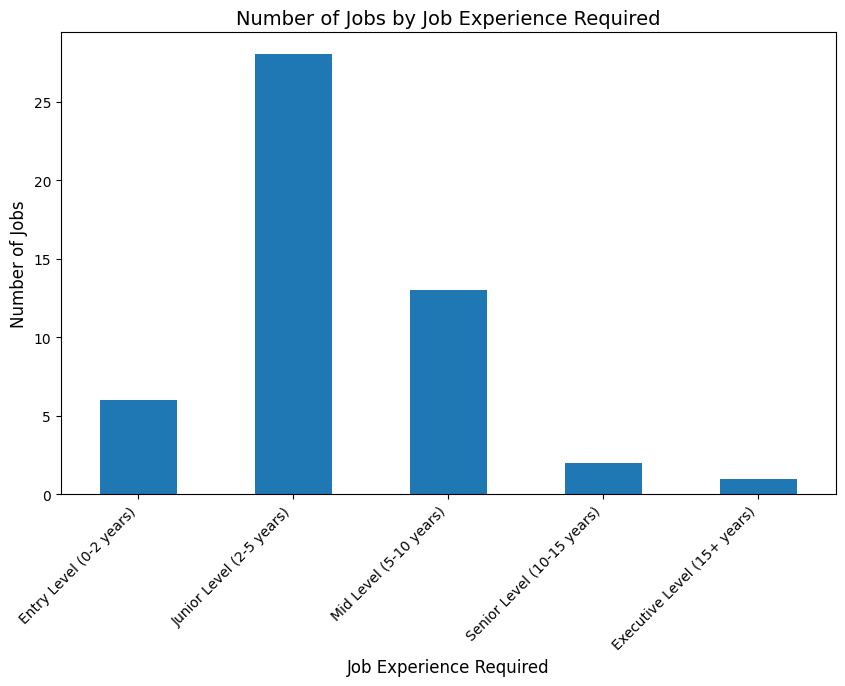

In [ ]:
# Get Counts by Job Experience Bucket
exp_counts = job_descriptions['exp_level'].value_counts()
exp_counts = exp_counts.sort_index(ascending= True)

# Plot the Number of Jobs by Job Experience Required
exp_counts.plot(kind='bar')
plt.title('Number of Jobs by Job Experience Required', fontsize=14)
plt.xlabel('Job Experience Required', fontsize=12)
plt.xticks(ticks=[0 ,1, 2, 3, 4], labels=['Entry Level (0-2 years)', 'Junior Level (2-5 years)', 
                                        'Mid Level (5-10 years)', 'Senior Level (10-15 years)' ,'Executive Level (15+ years)' ])
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

In [51]:
salary_counts = job_descriptions['salary_bucket'].value_counts()
salary_counts = salary_counts.sort_index(ascending= True)
print(salary_counts)

salary_bucket
0    21
1     5
2     6
3     3
4     4
5     5
6     6
Name: count, dtype: int64


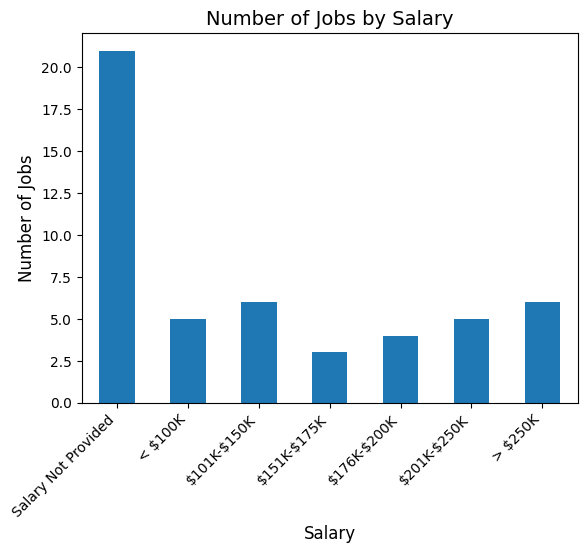

In [ ]:
# Get Counts by Salary Bucket
salary_counts = job_descriptions['salary_bucket'].value_counts()
salary_counts = salary_counts.sort_index(ascending= True)

# Plot the Number of Jobs by Salary
salary_counts.plot(kind='bar')
plt.title('Number of Jobs by Salary', fontsize=14)
plt.xlabel('Salary', fontsize=12)
plt.xticks(ticks=[0 ,1, 2, 3, 4 , 5, 6], labels=['Salary Not Provided', '< $100K', 
                                        '\\$101K-$150K', '\\$151K-$175K' ,'\\$176K-$200K', '\\$201K-$250K', '> $250K' ])
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')


# Show plot
plt.show()

### Identifying Most Common Technical Skills Required

In [ ]:
tech_skills_totals = job_descriptions[['SQL', 'R', 'Python', 'A/B Testing', 'Data Modeling', 'Data Visualization',  'Machine Learning']].sum()
print(tech_skills_totals)
print(type(tech_skills_totals))

SQL                   24
R                     14
Python                43
A/B Testing            8
Data Modeling          3
Data Visualization    17
Machine Learning      44
dtype: int64
<class 'pandas.core.series.Series'>


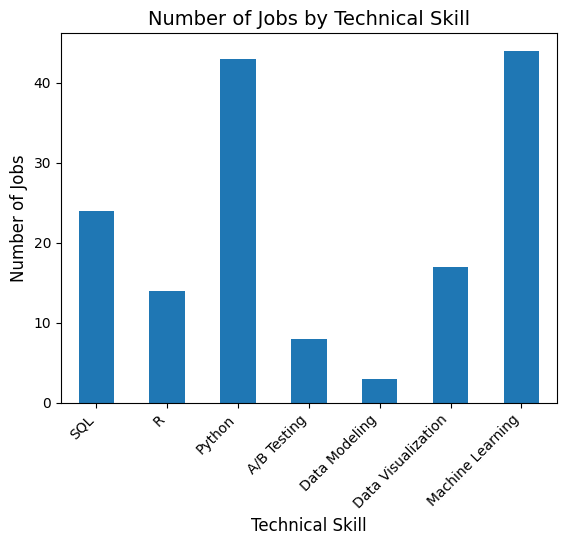

In [68]:
tech_skills_totals = job_descriptions[['SQL', 'R', 'Python', 'A/B Testing', 'Data Modeling', 'Data Visualization',  'Machine Learning']].sum()

# Plot the Number of Jobs for Each Tech Skill
tech_skills_totals.plot(kind='bar')
plt.title('Number of Jobs by Technical Skill', fontsize=14)
plt.xlabel('Technical Skill', fontsize=12)
#plt.xticks(ticks=[0 ,1, 2, 3, 4 , 5, 6], labels=['Salary Not Provided', '< $100K', 
#                                        '\\$101K-$150K', '\\$151K-$175K' ,'\\$176K-$200K', '\\$201K-$250K', '> $250K' ])
plt.ylabel('Number of Jobs', fontsize=12)
plt.xticks(rotation=45, ha='right')


# Show plot
plt.show()

### Filtering By Technical Skills Required, Sort by Salary

In [ ]:
pd.set_option('display.max_colwidth', None)
job_descriptions[job_descriptions["A/B Testing"] == 1 ][["Title", "Company", "salary" , "salary_bucket", "A/B Testing", "Url",]].sort_values("salary_bucket", ascending = False)

,Title,Company,salary,salary_bucket,A/B Testing,Url
0,Data Scientist (L5) - App QoE,Netflix,"$170,000 - $720,000",6,1,https://www.linkedin.com/jobs/view/data-scientist-l5-app-qoe-at-netflix-4208340911
1,Machine Learning Engineer,Netflix,"$100,000 - $720,000",6,1,https://www.linkedin.com/jobs/view/machine-learning-engineer-at-netflix-4118831761
2,"Data Scientist, Analytics",Discord,"$160,000 to $180,000",4,1,https://www.linkedin.com/jobs/view/data-scientist-analytics-at-discord-4222400361
8,"Data Scientist, Product Analytics",Meta,"$145,000/year to $204,000/year",4,1,https://www.linkedin.com/jobs/view/data-scientist-product-analytics-at-meta-4182238808
47,Machine Learning Engineer,The Phoenix Group,"$130,000 – $170,000",3,1,https://www.linkedin.com/jobs/view/machine-learning-engineer-at-the-phoenix-group-4224749425
16,Data Scientist,ImpetusIT,$55k-$70k,1,1,https://www.linkedin.com/jobs/view/data-scientist-at-impetusit-4225049438
29,Data Scientist,Super.com,No Salary Provided,0,1,https://www.linkedin.com/jobs/view/data-scientist-at-super-com-4225916439
34,Remote Data Scientist,Lensa,No Salary Provided,0,1,https://www.linkedin.com/jobs/view/remote-data-scientist-at-lensa-4225842655
